In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch

In [2]:
import numpy as np
import cv2
import mat73
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math
import torch.nn.functional as F

In [4]:
np.random.seed(42)

folder_dir = '/home/m123/stefano/data_np/'

mat_files = sorted([file for file in os.listdir(folder_dir) if file.endswith('.npy')])
idx = 33

print(mat_files[idx])

Flash_refl_50Hz_5J_Tamb_2_0000.npy


In [5]:
image_sequence = np.load(folder_dir + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

In [6]:
image_sequence.shape

(345, 640, 4527)

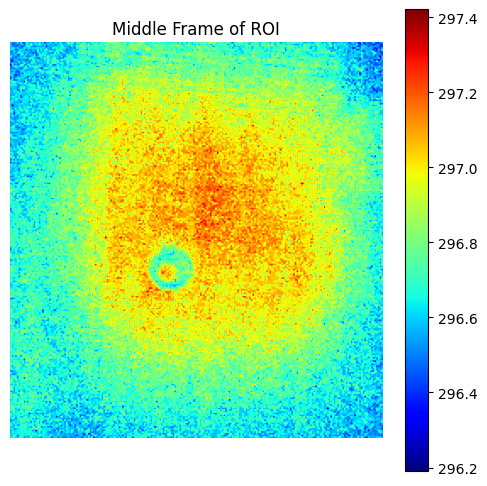

In [7]:
y1, y2, x1, x2 = 74, 308, 192, 412
image_sequence = image_sequence[y1:y2, x1:x2, :]

# image_sequence = image_sequence[5:, 110:540, :]

h, w, t = image_sequence.shape
middle_frame = image_sequence[:, :, t // 2]
plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

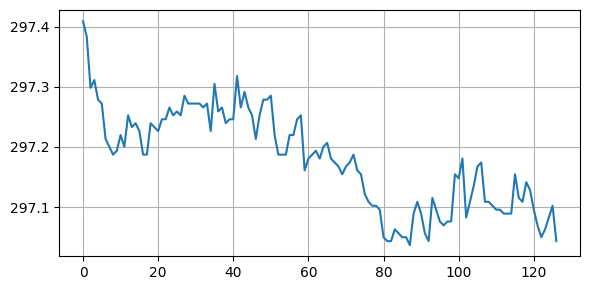

12


In [8]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 13

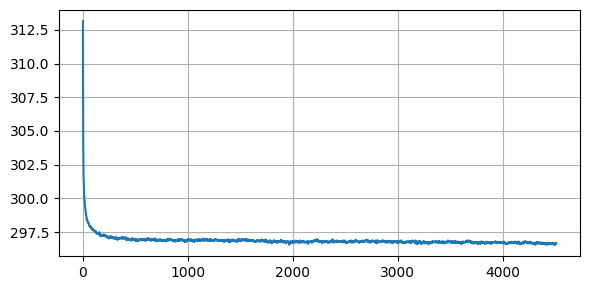

In [9]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

n_components = 10
latent_dim = n_components

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()

        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=8, dim_feedforward=512, batch_first=True),
                num_layers=2
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')

        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)

        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)

        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )


    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)

        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:3000]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [13]:
import torch.nn.functional as F

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f}, Z = {loss_recon_z.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f}, Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 0.3930 | Recon = 0.3508, Z = 0.0421
Epoch 10: Total Loss = 0.0063 | Recon = 0.0056, Z = 0.0007
Epoch 20: Total Loss = 0.0039 | Recon = 0.0033, Z = 0.0006
Epoch 30: Total Loss = 0.0035 | Recon = 0.0031, Z = 0.0004
Epoch 40: Total Loss = 0.0031 | Recon = 0.0028, Z = 0.0002
Epoch 50: Total Loss = 0.0031 | Recon = 0.0029, Z = 0.0002
Epoch 60: Total Loss = 0.0032 | Recon = 0.0030, Z = 0.0002
Epoch 70: Total Loss = 0.0030 | Recon = 0.0028, Z = 0.0002
Epoch 80: Total Loss = 0.0030 | Recon = 0.0029, Z = 0.0001
Epoch 90: Total Loss = 0.0031 | Recon = 0.0030, Z = 0.0001
Epoch 100: Total Loss = 0.0032 | Recon = 0.0031, Z = 0.0001


In [14]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())

principal_comp = torch.cat(all_latents, dim=0).numpy()

In [15]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

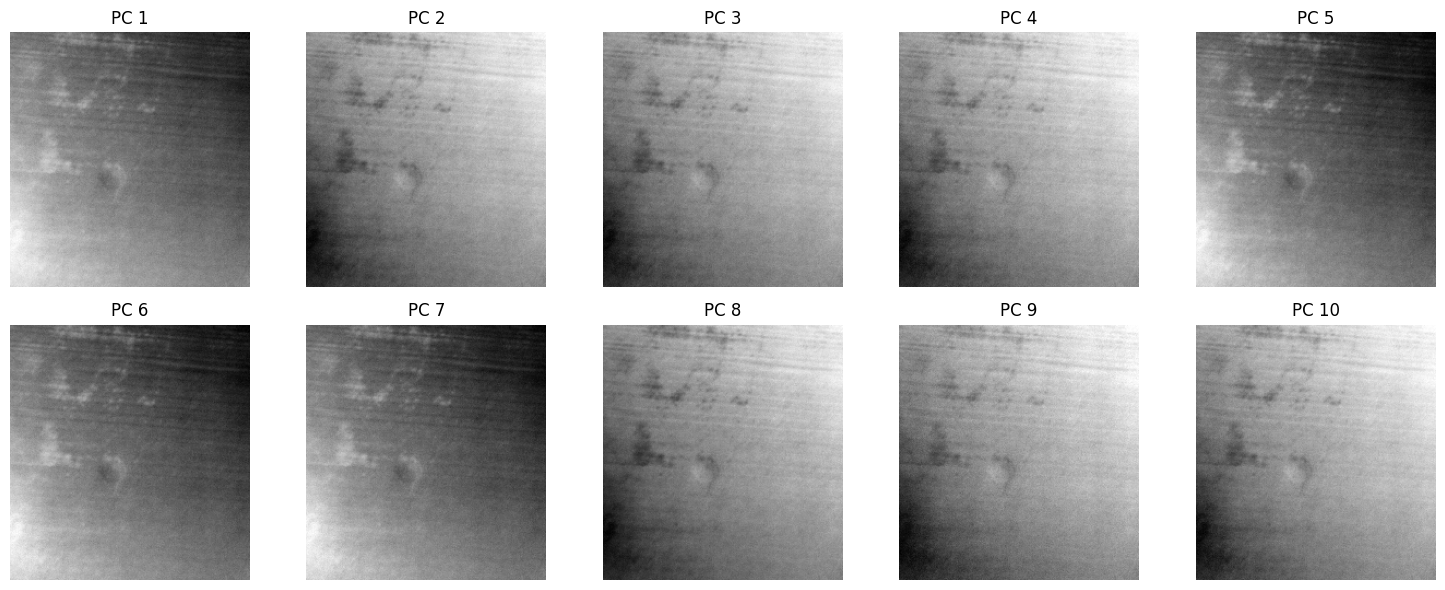

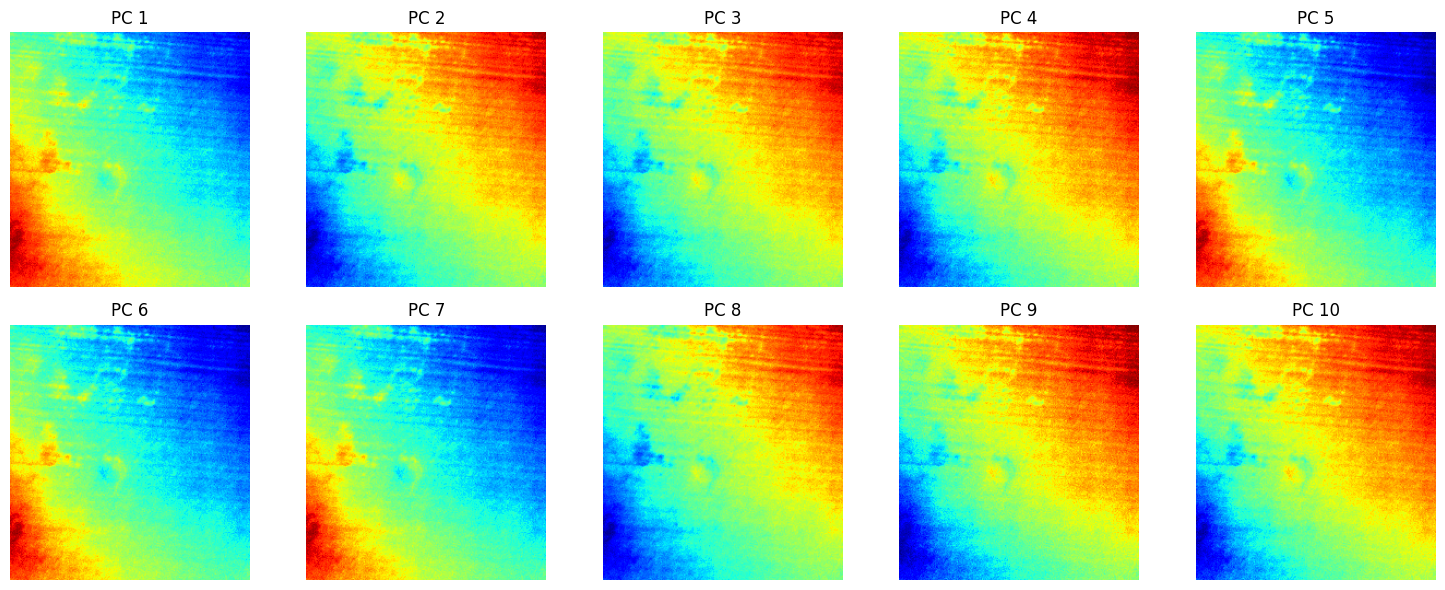

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

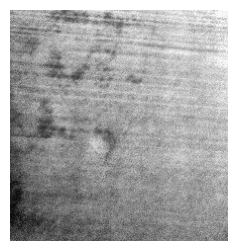

In [17]:
import torch
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

C, H, W = pca_array.shape
flat = pca_array.reshape(C, -1).T

pca = PCA(n_components=1)
pca_result = pca.fit_transform(flat)
comp = pca_result.reshape(H, W)

# comp = np.max(pca_array, axis=0)
comp = np.mean(pca_array, axis=0)

comp -= comp.min()
comp /= comp.max()

comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_8u = clahe.apply(gray_8u)

bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(3, 3))
plt.imshow(img_rgb, cmap='gray')
plt.axis('off')
plt.show()

In [1]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

/home/m123/anaconda3/envs/florence/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/m123/anaconda3/envs/florence/lib/python3.10/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [2]:
text_labels = [["a defect", "a thermal defect", "an anomaly", "a thermal anomaly"]]

In [19]:
# image = Image.fromarray(img_rgb).convert("RGB")
image = Image.open("temp_image.jpg")

inputs = processor(images=image, text=text_labels, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.5,
    text_threshold=0.5,
    target_sizes=[image.size[::-1]]
)

/tmp/ipykernel_5159/3781814536.py:8: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  results = processor.post_process_grounded_object_detection(


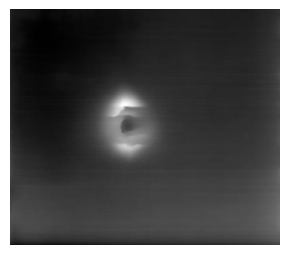

In [20]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(3, 3))
ax.imshow(image)

img_width, img_height = image.size
img_area = img_width * img_height

result = results[0]
boxes = []
scores = []
labels_list = []

for box, score, label in zip(result["boxes"], result["scores"], result["labels"]):
    x1, y1, x2, y2 = [x.item() for x in box]
    width, height = x2 - x1, y2 - y1
    box_area = width * height

    if box_area < 0.8 * img_area:
        boxes.append([x1, y1, x2, y2])
        scores.append(score.item())
        labels_list.append(label)

if boxes:
    boxes_tensor = torch.tensor(boxes)
    scores_tensor = torch.tensor(scores)

    top_idx = torch.argmax(scores_tensor).item()
    x1, y1, x2, y2 = boxes_tensor[top_idx].tolist()
    label = labels_list[top_idx]
    score = scores[top_idx]
    width, height = x2 - x1, y2 - y1

    rect = patches.Rectangle((x1, y1), width, height, linewidth=2,
                             edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
data = np.load("qwen/" + mat_files[idx] + ".npz")
gt_box = data["gt_box"]

pred_box = [x1, y1, x2, y2]

In [ ]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return inter / (areaA + areaB - inter) if (areaA + areaB - inter) != 0 else 0

def center_distance(boxA, boxB):
    cxA = (boxA[0] + boxA[2]) / 2.0
    cyA = (boxA[1] + boxA[3]) / 2.0
    cxB = (boxB[0] + boxB[2]) / 2.0
    cyB = (boxB[1] + boxB[3]) / 2.0
    return np.sqrt((cxA - cxB) ** 2 + (cyA - cyB) ** 2)


def normalized_center_distance(boxA, boxB, width, height):
    d = center_distance(boxA, boxB)
    diag = np.sqrt(width**2 + height**2)
    return d / diag

iou = compute_iou(gt_box, pred_box)
dist = center_distance(gt_box, pred_box)
norm_dist = normalized_center_distance(gt_box, pred_box, width=img_rgb.shape[1], height=img_rgb.shape[0])

In [ ]:
print(f"IoU: {iou}")
print(f"Center Distance: {dist}") 
print(f"Normalized Center Distance: {norm_dist}")

In [ ]:
np.savez("grounding_dino/" + mat_files[idx] + ".npz",
         original=img_rgb,
         gt_box=gt_box,
         pred_box=np.array([x1, y1, x2, y2]))